In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
import os

# -------------------------
# Hyperparamètres
# -------------------------
ENV_NAME = "Hopper-v5"
SEED = 42
MAX_STEPS = 300000      # Augmenté pour de meilleurs résultats sur Hopper
START_STEPS = 5000      # Plus d'exploration initiale
UPDATE_AFTER = 1000     
UPDATE_EVERY = 50       
BATCH_SIZE = 256
GAMMA = 0.99            
TAU = 0.005             
POLICY_LR = 3e-4        
Q_LR = 3e-4             
ALPHA_LR = 3e-4         
HIDDEN = 256            
REPLAY_SIZE = int(1e6)  
AUTOMATIC_ENTROPY_TUNING = True   

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", DEVICE)

# -------------------------
# Utils : Replay Buffer
# -------------------------
Transition = namedtuple("Transition", ("s", "a", "r", "s2", "done"))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

# -------------------------
# Networks
# -------------------------
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=HIDDEN, activation=nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            activation(),
            nn.Linear(hidden, hidden),
            activation(),
            nn.Linear(hidden, output_dim)
        )
        self.net.apply(weight_init)

    def forward(self, x):
        return self.net(x)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=HIDDEN):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.net.apply(weight_init)

    def forward(self, s, a):
        x = torch.cat([s, a], dim=-1)
        return self.net(x)

LOG_STD_MIN = -20
LOG_STD_MAX = 2

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=HIDDEN):
        super().__init__()
        self.shared = MLP(state_dim, 2 * action_dim, hidden=hidden)
        self.action_dim = action_dim

    def forward(self, s):
        x = self.shared(s)
        mu, log_std = x[:, :self.action_dim], x[:, self.action_dim:]
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = log_std.exp()
        return mu, std

    def sample(self, s):
        mu, std = self.forward(s)
        dist = torch.distributions.Normal(mu, std)
        z = dist.rsample()
        action = torch.tanh(z)
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob, torch.tanh(mu)

# -------------------------
# Agent SAC
# -------------------------
class SACAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.act_limit = float(env.action_space.high[0])

        self.policy = GaussianPolicy(self.state_dim, self.action_dim).to(DEVICE)
        self.q1 = QNetwork(self.state_dim, self.action_dim).to(DEVICE)
        self.q2 = QNetwork(self.state_dim, self.action_dim).to(DEVICE)
        self.q1_target = QNetwork(self.state_dim, self.action_dim).to(DEVICE)
        self.q2_target = QNetwork(self.state_dim, self.action_dim).to(DEVICE)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.policy_opt = optim.Adam(self.policy.parameters(), lr=POLICY_LR)
        self.q1_opt = optim.Adam(self.q1.parameters(), lr=Q_LR)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=Q_LR)

        if AUTOMATIC_ENTROPY_TUNING:
            self.target_entropy = -float(self.action_dim)
            self.log_alpha = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True, device=DEVICE))
            self.alpha_opt = optim.Adam([self.log_alpha], lr=ALPHA_LR)
        else:
            self.alpha = 0.2

    def select_action(self, state, evaluate=False):
        s = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            if evaluate:
                _, _, action = self.policy.sample(s)
            else:
                action, _, _ = self.policy.sample(s)
        return action.cpu().numpy().squeeze(0) * self.act_limit

    def update(self, replay_buffer, batch_size):
        transitions = replay_buffer.sample(batch_size)
        s = torch.FloatTensor(np.array(transitions.s)).to(DEVICE)
        a = torch.FloatTensor(np.array(transitions.a)).to(DEVICE)
        r = torch.FloatTensor(np.array(transitions.r)).to(DEVICE).unsqueeze(-1)
        s2 = torch.FloatTensor(np.array(transitions.s2)).to(DEVICE)
        done = torch.FloatTensor(np.array(transitions.done)).to(DEVICE).unsqueeze(-1)

        # Normalisation pour le Critic
        a_scaled = a / self.act_limit

        with torch.no_grad():
            a2, logp_a2, _ = self.policy.sample(s2)
            # Important : a2 est déjà entre -1 et 1 car sorti par tanh
            q1_t = self.q1_target(s2, a2)
            q2_t = self.q2_target(s2, a2)
            q_target_min = torch.min(q1_t, q2_t)
            alpha = self.log_alpha.exp() if AUTOMATIC_ENTROPY_TUNING else self.alpha
            y = r + GAMMA * (1 - done) * (q_target_min - alpha * logp_a2)

        # Update Critics
        q1_loss = torch.nn.functional.mse_loss(self.q1(s, a_scaled), y)
        q2_loss = torch.nn.functional.mse_loss(self.q2(s, a_scaled), y)

        self.q1_opt.zero_grad(); q1_loss.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); q2_loss.backward(); self.q2_opt.step()

        # Update Policy
        a_new, logp_new, _ = self.policy.sample(s)
        q_new_min = torch.min(self.q1(s, a_new), self.q2(s, a_new))
        
        alpha = self.log_alpha.exp() if AUTOMATIC_ENTROPY_TUNING else self.alpha
        policy_loss = (alpha * logp_new - q_new_min).mean()

        self.policy_opt.zero_grad(); policy_loss.backward(); self.policy_opt.step()

        # Alpha tuning
        if AUTOMATIC_ENTROPY_TUNING:
            alpha_loss = -(self.log_alpha * (logp_new + self.target_entropy).detach()).mean()
            self.alpha_opt.zero_grad(); alpha_loss.backward(); self.alpha_opt.step()

        # Soft update
        for p, tp in zip(self.q1.parameters(), self.q1_target.parameters()):
            tp.data.copy_(TAU * p.data + (1 - TAU) * tp.data)
        for p, tp in zip(self.q2.parameters(), self.q2_target.parameters()):
            tp.data.copy_(TAU * p.data + (1 - TAU) * tp.data)


Device utilisé : cuda


In [2]:
# -------------------------
# Boucle principale
# -------------------------
env = gym.make(ENV_NAME)
env.reset(seed=SEED)
np.random.seed(SEED); torch.manual_seed(SEED); random.seed(SEED)

agent = SACAgent(env)
replay = ReplayBuffer(REPLAY_SIZE)

# Historique pour les plots
history_returns = []
history_steps = []

total_steps = 0
episode = 0
state, _ = env.reset()

while total_steps < MAX_STEPS:
    if total_steps < START_STEPS:
        action = env.action_space.sample()
    else:
        action = agent.select_action(state, evaluate=False)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay.push(state, action, reward, next_state, float(done))

    state = next_state
    total_steps += 1

    if done:
        episode += 1
        # Évaluation périodique (tous les épisodes ici pour le plot)
        eval_return = 0
        s_eval, _ = env.reset()
        d_eval = False
        while not d_eval:
            a_eval = agent.select_action(s_eval, evaluate=True)
            s_eval, r_eval, term, trunc, _ = env.step(a_eval)
            eval_return += r_eval
            d_eval = term or trunc
        
        history_returns.append(eval_return)
        history_steps.append(total_steps)
        
        if episode % 10 == 0:
            print(f"Épisode {episode} | Steps {total_steps} | Return Eval {eval_return:.2f}")
        
        state, _ = env.reset()

    if total_steps >= UPDATE_AFTER and total_steps % UPDATE_EVERY == 0:
        for _ in range(UPDATE_EVERY):
            if len(replay) >= BATCH_SIZE:
                agent.update(replay, BATCH_SIZE)

env.close()



Épisode 10 | Steps 166 | Return Eval 46.39
Épisode 20 | Steps 437 | Return Eval 43.11
Épisode 30 | Steps 628 | Return Eval 43.49
Épisode 40 | Steps 819 | Return Eval 45.51
Épisode 50 | Steps 1032 | Return Eval 45.03
Épisode 60 | Steps 1393 | Return Eval 97.93
Épisode 70 | Steps 1602 | Return Eval 82.05
Épisode 80 | Steps 1920 | Return Eval 75.65
Épisode 90 | Steps 2148 | Return Eval 83.46
Épisode 100 | Steps 2401 | Return Eval 74.24
Épisode 110 | Steps 2618 | Return Eval 71.75
Épisode 120 | Steps 2867 | Return Eval 81.89
Épisode 130 | Steps 3111 | Return Eval 72.91
Épisode 140 | Steps 3301 | Return Eval 81.20
Épisode 150 | Steps 3482 | Return Eval 125.95
Épisode 160 | Steps 3706 | Return Eval 101.60
Épisode 170 | Steps 3953 | Return Eval 47.76
Épisode 180 | Steps 4145 | Return Eval 51.08
Épisode 190 | Steps 4326 | Return Eval 136.64
Épisode 200 | Steps 4586 | Return Eval 148.23
Épisode 210 | Steps 4801 | Return Eval 138.09
Épisode 220 | Steps 4985 | Return Eval 87.70
Épisode 230 | Step

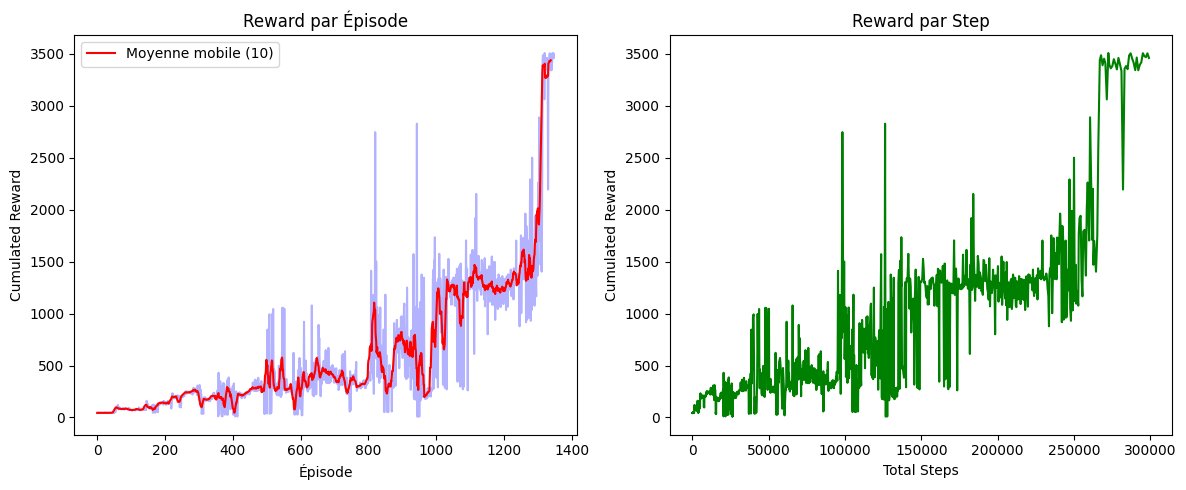

In [3]:
# -------------------------
# Visualisation des résultats
# -------------------------
plt.figure(figsize=(12, 5))

# Plot Reward vs Episodes
plt.subplot(1, 2, 1)
plt.plot(history_returns, color='blue', alpha=0.3)
# Moyenne mobile pour lisser
if len(history_returns) > 10:
    smoothed = np.convolve(history_returns, np.ones(10)/10, mode='valid')
    plt.plot(smoothed, color='red', label='Moyenne mobile (10)')
plt.title("Reward par Épisode")
plt.xlabel("Épisode")
plt.ylabel("Cumulated Reward")
plt.legend()

# Plot Reward vs Steps
plt.subplot(1, 2, 2)
plt.plot(history_steps, history_returns, color='green')
plt.title("Reward par Step")
plt.xlabel("Total Steps")
plt.ylabel("Cumulated Reward")

plt.tight_layout()
plt.show()

In [10]:
import gymnasium as gym
import torch
import numpy as np
import time

# --- Configuration du test ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_episodes = 3

# --- Créer l'environnement avec rendu ---
# render_mode="human" permet de voir l'agent sauter
env_test = gym.make("Hopper-v5", render_mode="human")

# TRÈS IMPORTANT : Le wrapper NormalizeObservation doit être présent 
# si l'agent a été entraîné avec, sinon ses entrées seront faussées.
env_test = gym.wrappers.NormalizeObservation(env_test)

# S'assurer que le modèle est chargé et en mode évaluation
# On utilise directement mu (la moyenne) pour une performance maximale et stable
agent.policy.eval() 

for ep in range(num_episodes):
    obs, _ = env_test.reset()
    done = False
    total_reward = 0
    steps = 0

    print(f"🎬 Lancement de l'épisode {ep + 1}...")

    while not done:
        # 1. Préparation de l'observation
        obs_t = torch.tensor(obs, dtype=torch.float32).to(device).unsqueeze(0)

        # 2. Sélection de l'action déterministe (Exploitation pure)
        with torch.no_grad():
            # Dans SAC, on utilise mu (la moyenne) pour le test
            mu, _ = agent.policy.forward(obs_t)
            # L'action optimale est le tanh de mu mis à l'échelle
            act = torch.tanh(mu) 
            action_numpy = act.cpu().numpy().squeeze(0) * agent.act_limit

        # 3. Exécution de l'action
        obs, reward, terminated, truncated, _ = env_test.step(action_numpy)
        done = terminated or truncated
        total_reward += reward
        steps += 1

        # Ralentissement pour l'affichage (ajuster selon votre PC)
        time.sleep(0.01) 

    print(f"✅ Épisode {ep + 1} terminé | Reward : {total_reward:.2f} | Steps : {steps}")
    time.sleep(1) # Pause entre les épisodes pour lire le résultat

env_test.close()
print("\nTest de performance terminé.")

🎬 Lancement de l'épisode 1...
✅ Épisode 1 terminé | Reward : 218.87 | Steps : 119
🎬 Lancement de l'épisode 2...
✅ Épisode 2 terminé | Reward : 101.19 | Steps : 59
🎬 Lancement de l'épisode 3...
✅ Épisode 3 terminé | Reward : 126.95 | Steps : 79

Test de performance terminé.
